In [1]:
import os, sys, glob, pdb, random, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchinfo
from importlib import reload

sys.path.append('../')  
import utils.ImageLoader as ImageLoader
import utils.LeafGenerator as LeafGenerator
from utils.GetLowestGPU import GetLowestGPU
import utils.ModelWrapperGenerator as MW
import models.BuildCNN as BuildCNN

if 'device' not in locals():
    device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 03326MiB / 40537MiB
  1  | 06238MiB / 40537MiB
  2  | 12396MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 02694MiB / 40537MiB
---------------------------
 Device set to cuda:3
---------------------------


# Load images

Loading data...


  0%|          | 0/50 [00:00<?, ?it/s]

Plotting examples...


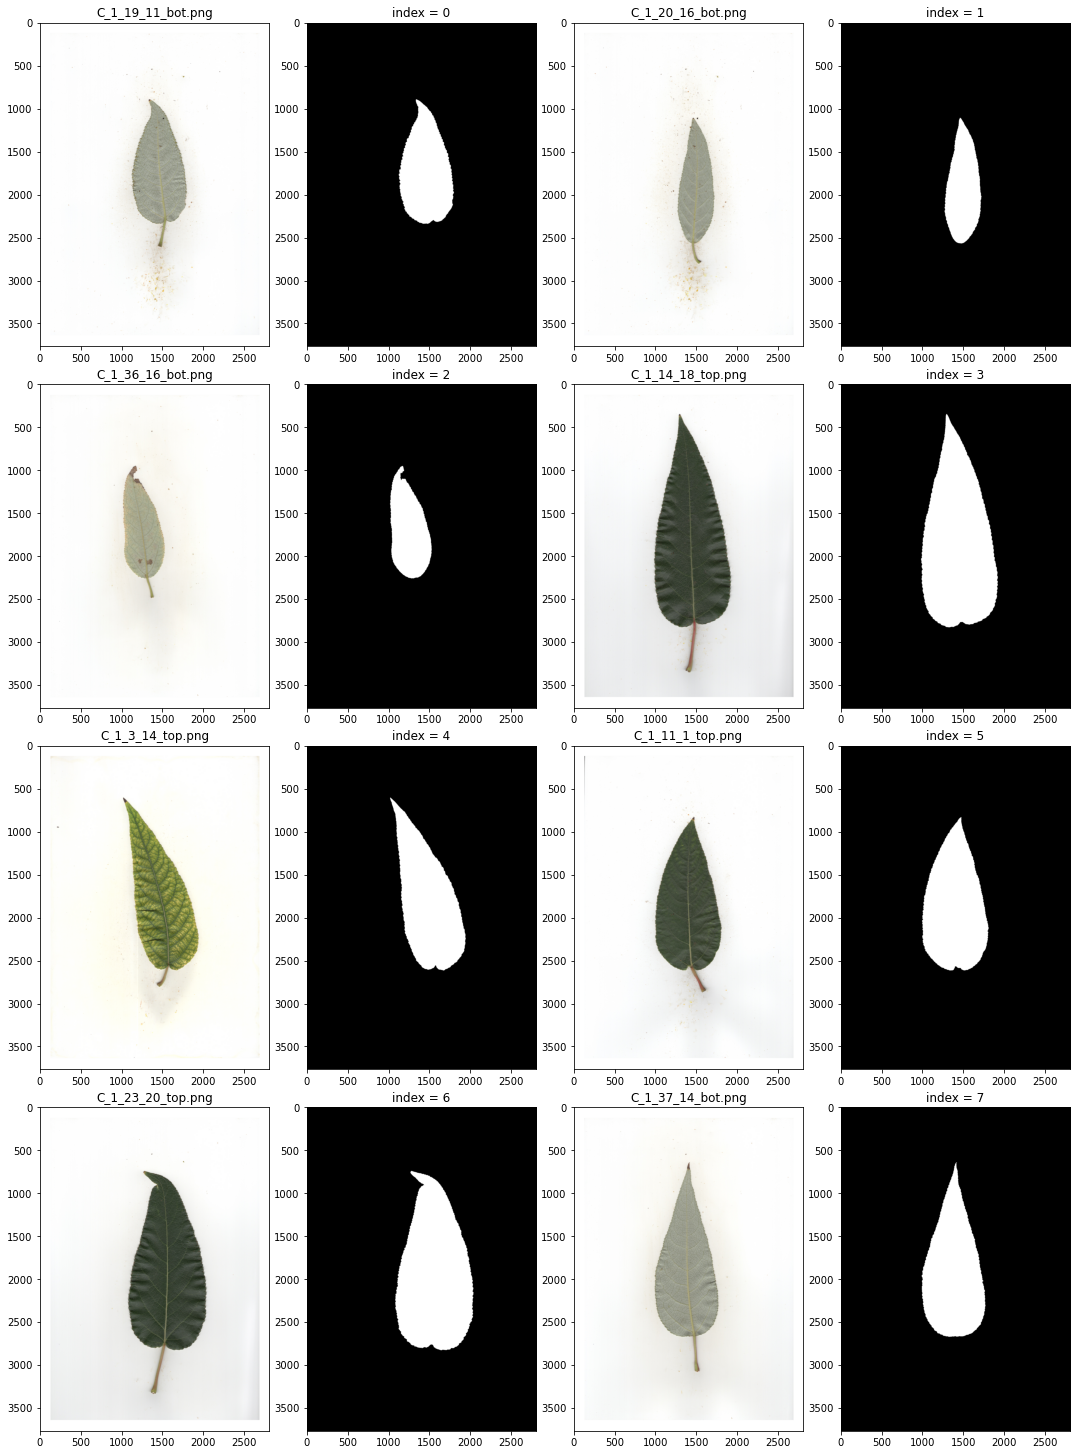

In [2]:
# options
image_path = '../data/images/'
mask_path = '../data/leaf_masks/'
image_extension = '.jpeg'
mask_extension = '.png'
window_size = 256
pad = True
verbose=True
plot = True
figsize = 5

# initialize loader
reload(ImageLoader)
IL = ImageLoader.ImageLoader(
    image_path=image_path, 
    mask_path=mask_path,  
    image_ext=image_extension,
    mask_ext=mask_extension,
    window_size=window_size, 
    pad=pad,
    verbose=verbose)

# load data
print('Loading data...'); time.sleep(0.3)
images, masks = IL.load_data()
file_names = IL.file_names

# plot
if plot:
    print('Plotting examples...')
    size = [images[0].shape[0], images[0].shape[1]]
    n_rows = min(np.ceil(len(IL)/2), 8)
    fig = plt.figure(figsize=(4*size[1]/size[0]*figsize, n_rows*figsize))
    for i in range(min(len(IL), 8)):
        ax = fig.add_subplot(n_rows, 4, 2*i+1)
        plt.imshow(images[i], aspect='auto')
        plt.title(file_names[i])
        ax = fig.add_subplot(n_rows, 4, 2*i+2)
        plt.imshow(masks[i], aspect='auto', cmap='gray')
        plt.title('index = {0}'.format(i))
    plt.tight_layout(pad=0.5)
    plt.show()

# Make data loader

Val index: [35 33 12  7 31 16 26 45  5 29]

Extracting contours...


  0%|          | 0/40 [00:00<?, ?it/s]

Extracting contours...


  0%|          | 0/10 [00:00<?, ?it/s]

Train: 244,958, Val: 55,690

Plotting training examples...


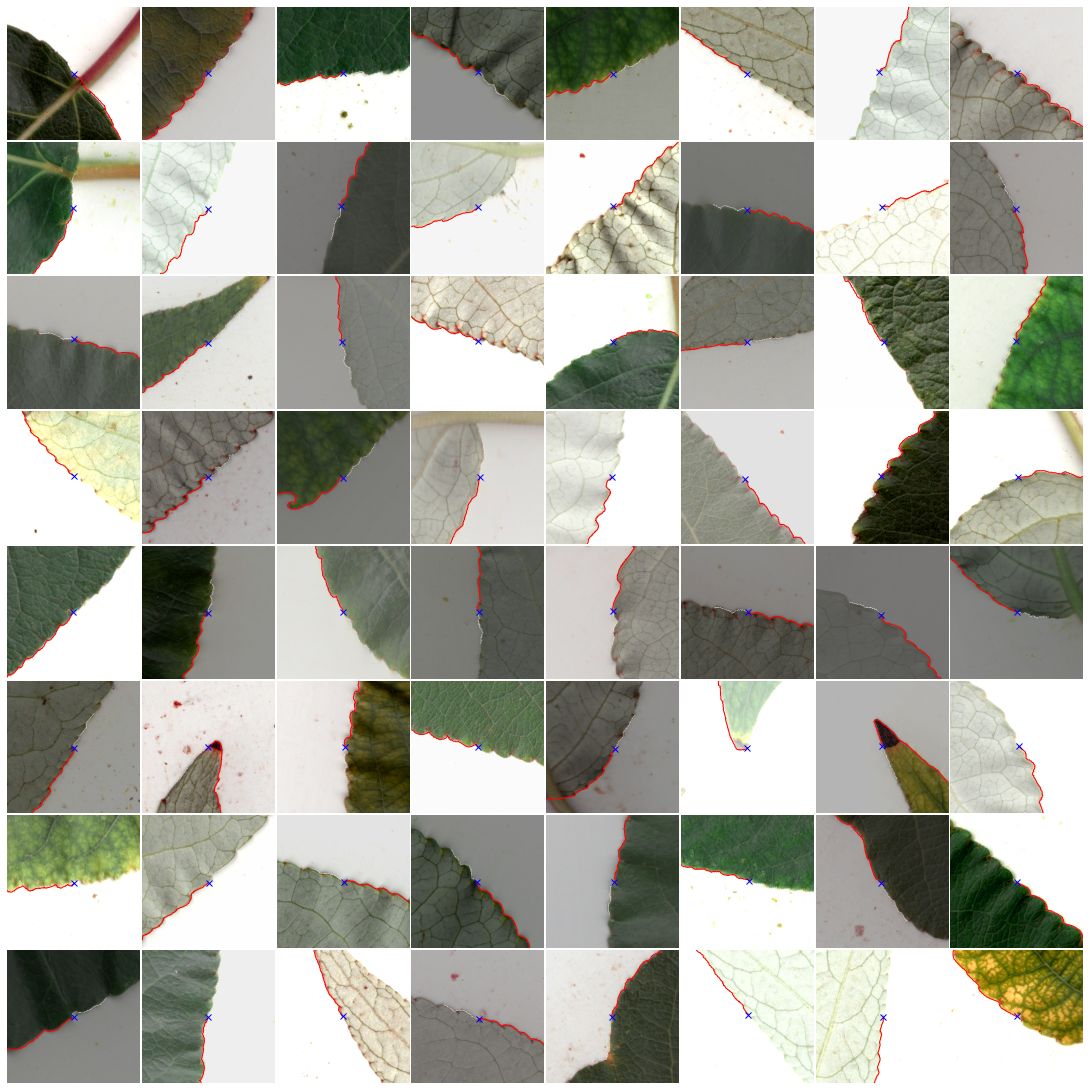

In [3]:
# options
path_length = int(window_size/2) # half of window size
step_length = int(path_length/2) # half of path length
plot = True
verbose = True

# split images into train/val sets
p = np.random.permutation(len(masks))
train_img_idx = p[:int(0.8*len(p))]
val_img_idx = p[int(0.8*len(p)):]
print('Val index: {0}'.format(val_img_idx))
print()

# instantiate data loaders
reload(LeafGenerator)
train_dataset = LeafGenerator.LeafGenerator(
    images=[images[i] for i in train_img_idx], 
    masks=[masks[i] for i in train_img_idx], 
    path_length=path_length,
    step_length=step_length,
    window_size=window_size, 
    augment=True,
    verbose=verbose)
val_dataset = LeafGenerator.LeafGenerator(
    images=[images[i] for i in val_img_idx], 
    masks=[masks[i] for i in val_img_idx], 
    path_length=path_length,
    step_length=step_length,
    window_size=window_size, 
    augment=False,
    verbose=verbose)
print('Train: {0:,}, Val: {1:,}'.format(len(train_dataset), len(val_dataset)))
print()

# plot example input/output tiles
if plot:
    print('Plotting training examples...')
    fig = plt.figure(figsize=(15,15))
    N = len(train_dataset)
    for i in range(64):
        rand_idx = np.random.choice(N)
        input, output = train_dataset[rand_idx]
        tile = train_dataset.image2numpy(input)
        mask = train_dataset.mask2numpy(input[-1])
        output = output.detach().cpu().numpy()
        ax = fig.add_subplot(8, 8, i+1)
        plt.imshow((tile+mask[:,:,None]).clip(0,1), aspect='auto')
        plt.plot(window_size/2+output[0], window_size/2-output[1], 'r-', linewidth=1)
        plt.plot(window_size/2+output[0,0], window_size/2-output[1,0], 'bx')
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

# Train leaf tracing CNN

In [4]:
# options
layers = [4, 32, 32, 32, 32, 32, 64, 128]
output_shape = [2, path_length]
output_activation = None
save_name = f'leaf_tracer_{window_size}'

# initialize model and optimizer
reload(BuildCNN)
cnn = BuildCNN.CNN(
    window_size=window_size, 
    layers=layers,
    output_shape=output_shape,
    output_activation=output_activation).to(device)
opt = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# define loss function
def weighted_mse(pred, target):
    weights = torch.linspace(-4, 4, path_length, dtype=torch.float32)
    weights = 1 + (1 - torch.tanh(weights).to(pred.device))/2
    return torch.mean(weights * (pred - target)**2)

# wrap model
reload(MW)
model = MW.ModelWrapper(
    model=cnn,
    optimizer=opt,
    loss=weighted_mse,
    save_name=f'../weights/{save_name}',
    log_name=f'../logs/{save_name}.txt',
    device=device)

# model summary
torchinfo.summary(
    cnn, 
    input_size=(1, 4, window_size, window_size), 
    device=device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─BuildCNN: 1                            --                        --
│    └─ModuleList: 2-1                   --                        --
│    └─ModuleList: 2-2                   --                        --
│    └─ModuleList: 2-3                   --                        --
│    └─ModuleList: 2-4                   --                        --
├─BuildCNN: 1-1                          [1, 128, 4, 4]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [1, 32, 256, 256]         1,184
│    └─ModuleList: 2-2                   --                        --
│    │    └─BatchNorm2d: 3-2             [1, 32, 256, 256]         64
│    └─LeakyReLU: 2-5                    [1, 32, 256, 256]         --
│    └─ModuleList: 2-1                   --                        --
│    │    └─

In [ ]:
# options
epochs = 1000
batch_size = 256
workers = 64
early_stopping = 20

# train 
model.fit(
    train_dataset=train_dataset,
    validation_dataset=val_dataset,
    batch_size=batch_size,
    epochs=epochs,
    early_stopping=early_stopping,
    verbose=2,
    workers=workers)

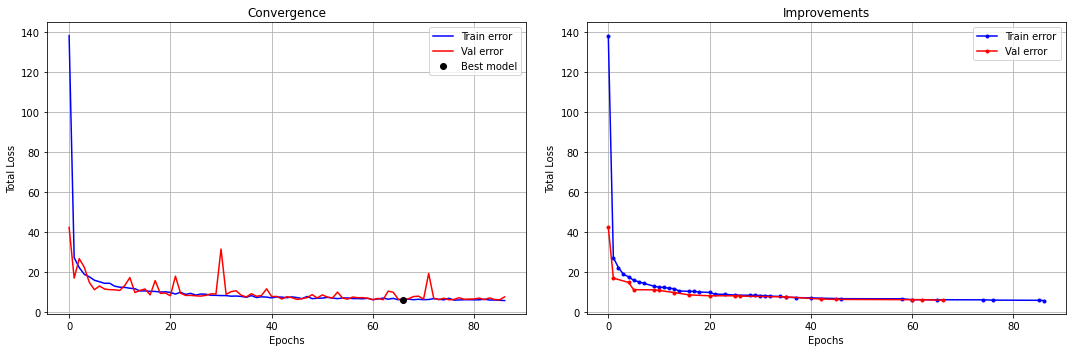

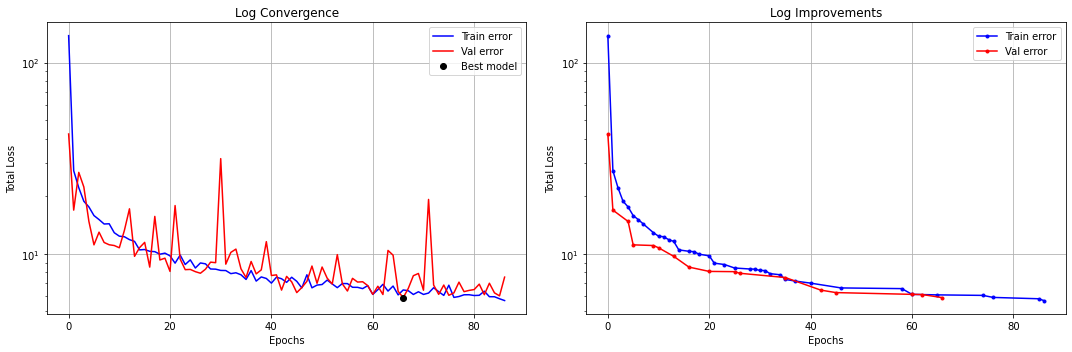

In [5]:
rel_save_thresh = 0.0

# load errors
total_train_losses, total_val_losses = [], []
with open(model.log_name, 'r') as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        line = line.split(',')
        total_train_losses.append(float(line[1]))
        total_val_losses.append(float(line[2]))

# find where errors decreased
train_idx, train_loss, val_idx, val_loss = [], [], [], []
best_train, best_val = 1e12, 1e12
for i in range(len(total_train_losses)):
    rel_diff = (best_train - total_train_losses[i])
    rel_diff /= best_train
    if rel_diff > rel_save_thresh:
        best_train = total_train_losses[i]
        train_idx.append(i)
        train_loss.append(best_train)
    rel_diff = (best_val - total_val_losses[i])
    rel_diff /= best_val
    if rel_diff > rel_save_thresh:
        best_val = total_val_losses[i]
        val_idx.append(i)
        val_loss.append(best_val)
idx = np.argmin(val_loss)

# plot errors and improvements
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(total_train_losses, 'b')
plt.plot(total_val_losses, 'r')
plt.plot(val_idx[idx], val_loss[idx], 'ko')
plt.legend([r'Train error', r'Val error', 'Best model'])
plt.xlabel(r'Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Convergence')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.plot(train_idx, train_loss, 'b.-')
plt.plot(val_idx, val_loss, 'r.-')
plt.legend([r'Train error', r'Val error'])
plt.xlabel('Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Improvements')
plt.grid()
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()

# plot log-scaled errors and improvements
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(total_train_losses, 'b')
plt.semilogy(total_val_losses, 'r')
plt.semilogy(val_idx[idx], val_loss[idx], 'ko')
plt.legend([r'Train error', r'Val error', 'Best model'])
plt.xlabel(r'Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Log Convergence')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.semilogy(train_idx, train_loss, 'b.-')
plt.semilogy(val_idx, val_loss, 'r.-')
plt.legend([r'Train error', r'Val error'])
plt.xlabel('Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Log Improvements')
plt.grid()
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()

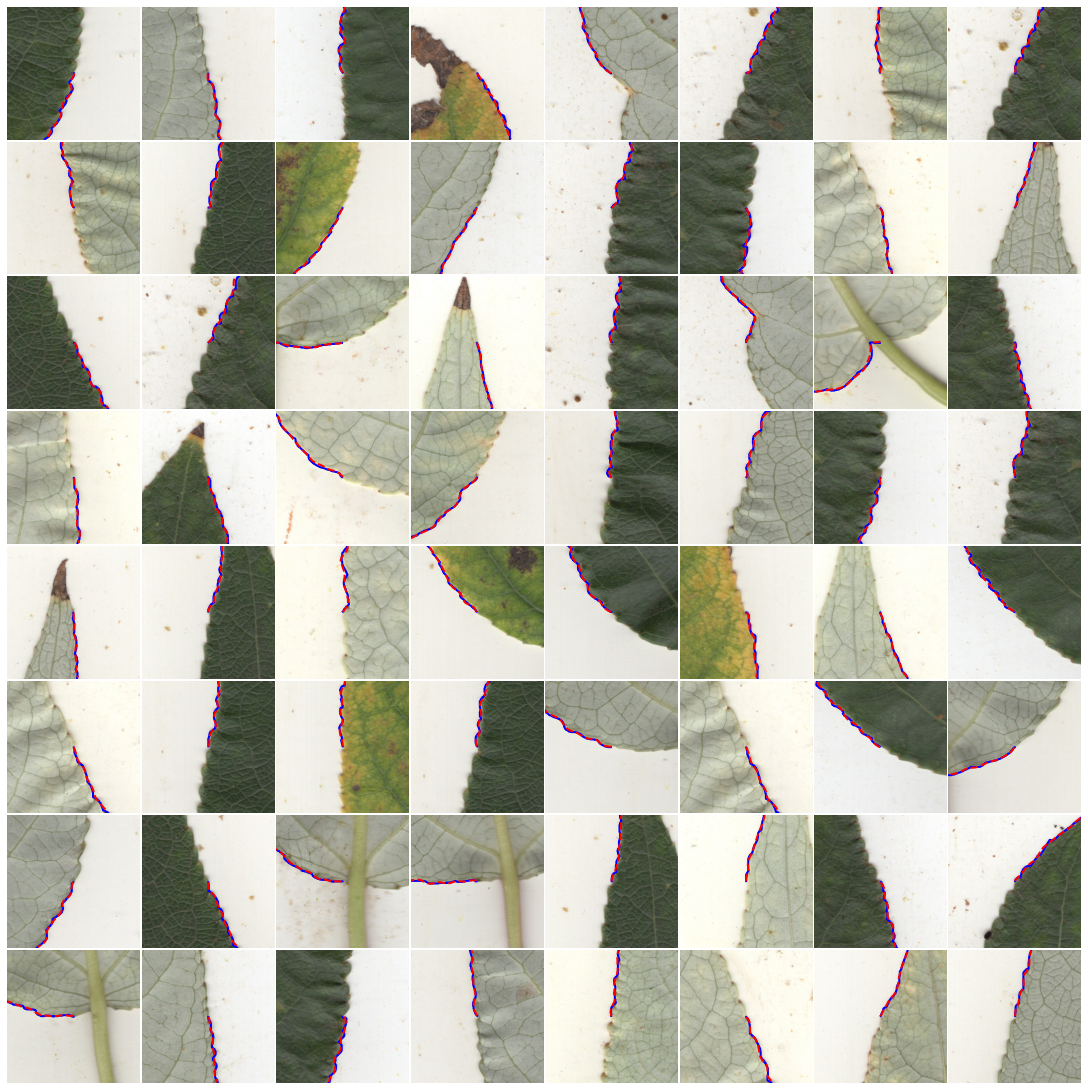

In [6]:
# load model weights
model.load_best_val(device=device)

# plot example inputs/outputs/predictions
fig = plt.figure(figsize=(15,15))
for i in range(64):
    
    # predict on random validation tile
    rand_idx = np.random.choice(len(val_dataset))
    tile, true = val_dataset[rand_idx]
    pred = model.predict(tile[None].to(device))[0]
    tile = val_dataset.image2numpy(tile)
    true = true.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    
    # plot tile, ground truth, and prediction
    ax = fig.add_subplot(8, 8, i+1)
    plt.imshow(tile, extent=[0, window_size, 0, window_size])
    plt.plot(window_size/2+true[0], window_size/2+true[1], 'b-', linewidth=2)
    plt.plot(window_size/2+pred[0], window_size/2+pred[1], 'r--', linewidth=2)
    plt.axis('off')
    plt.xlim([0, window_size])
    plt.ylim([0, window_size])
    
plt.tight_layout(pad=0.2)
plt.show()